In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [2]:
# from google.colab import drive
# drive.mount('/content/drive', readonly=True)

In [3]:
url = "https://ddc-datascience.s3.amazonaws.com/boston.csv"
boston = pd.read_csv( url, index_col = 0 )


In [4]:
boston.head()

,per_cap_crime,res_zoning_prop,business_prop,river_front,nitric_oxide_conc,num_rooms,units_before_1940,distance_to_employment,distance_to_hwy,prop_tax,pupil_teacher_ratio,perc_lower_status,med_home_value
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,5.33,36.2


In [5]:
boston.info()

<class 'pandas.core.frame.DataFrame'>
Index: 490 entries, 0 to 505
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   per_cap_crime           490 non-null    float64
 1   res_zoning_prop         490 non-null    float64
 2   business_prop           490 non-null    float64
 3   river_front             490 non-null    float64
 4   nitric_oxide_conc       490 non-null    float64
 5   num_rooms               490 non-null    float64
 6   units_before_1940       490 non-null    float64
 7   distance_to_employment  490 non-null    float64
 8   distance_to_hwy         490 non-null    float64
 9   prop_tax                490 non-null    float64
 10  pupil_teacher_ratio     490 non-null    float64
 11  perc_lower_status       490 non-null    float64
 12  med_home_value          490 non-null    float64
dtypes: float64(13)
memory usage: 53.6 KB


Recall that with a decision tree we got an RMSE of about \$3800, and with a random forest with got an RMSE of about \$2850.

#XGBoost

Here we are fitting an XGBoost model without specifying any hyperparameters.

In [6]:
X = boston.drop('med_home_value', axis = 1)
y = boston['med_home_value']

In [7]:
numLoops = 100
mse_xgb  = np.zeros(numLoops)

for idx in range(0,numLoops):
  X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15)
  xgbr = xgb.XGBRegressor(objective ='reg:squarederror', verbosity=0, seed = 10)
  xgbr.fit(X_train,y_train)
  y_pred_xgb = xgbr.predict(X_test)
  mse_xgb[idx] = mean_squared_error(y_test,y_pred_xgb)


print(f'RMSE: {np.sqrt(mse_xgb).mean()*1000}')

RMSE: 3016.021905965499


In [8]:
y_pred_xgb[0]

9.611709

In [20]:
y_test.to_numpy()[0]

11.0

In [21]:
my_house = X_test[:3]
my_house

,per_cap_crime,res_zoning_prop,business_prop,river_front,nitric_oxide_conc,num_rooms,units_before_1940,distance_to_employment,distance_to_hwy,prop_tax,pupil_teacher_ratio,perc_lower_status
428,7.36711,0.0,18.10,0.0,0.679,6.193,78.1,1.9356,24.0,666.0,20.2,21.52
287,0.03871,52.5,5.32,0.0,0.405,6.209,31.3,7.3172,6.0,293.0,16.6,7.14
452,5.09017,0.0,18.10,0.0,0.713,6.297,91.8,2.3682,24.0,666.0,20.2,17.27


In [22]:
xgbr.predict(my_house)

array([ 9.611709, 23.009007, 15.251231], dtype=float32)

## XGBoost with Parameters

Now we will see if we can improve performance by changing some parameters.

In [23]:
# Specify the parameters you want to try and their ranges.
param_test = {
 'max_depth'     : [ 3, 4, 5, 6, 7 ],
 'learning_rate' : [ 0.1, 0.2, 0.3, 0.4 ],
 'n_estimators'  : [ 20, 40, 60, 80, 100, 120, 140 ],
}

# Perform the grid search
gsearch = GridSearchCV(
    estimator = xgb.XGBRegressor( objective = 'reg:squarederror', seed = 10 ),
    param_grid = param_test,
    scoring = 'neg_mean_squared_error',
    cv = 5,
)

# Fit to training data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.05, random_state = 42 )
model = gsearch.fit(X_train,y_train)

# See grid search results
print(model.best_params_)

{'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100}


Now we will fit our XGBoost model with the best parameters

In [24]:
numLoops = 100
mse_xgb  = np.zeros(numLoops)

for idx in range(0,numLoops):
  X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.15 )
  xgbr = xgb.XGBRegressor(
      objective ='reg:squarederror',
      verbosity=0,
      learning_rate = 0.2,
      max_depth = 3,
      n_estimators = 100,
      seed = 10,
  )
  xgbr.fit(X_train,y_train)
  y_pred_xgb = xgbr.predict(X_test)
  mse_xgb[idx] = mean_squared_error(y_test,y_pred_xgb)

print(f'RMSE: {np.sqrt(mse_xgb).mean()*1000}')

RMSE: 2769.0589582935277


<ipython-input-25-16d4b8a6cfd6>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( ax.get_xticklabels(), rotation = 90 )


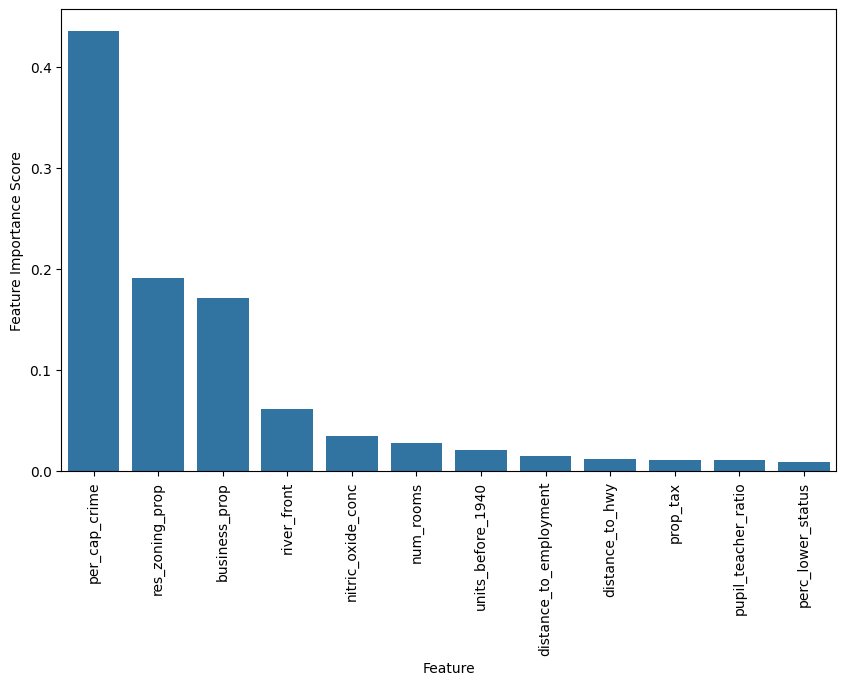

In [25]:
feat_imp = pd.Series(xgbr.feature_importances_, index=X.columns)
plt.figure(figsize = (10,6))
# ax = sns.barplot(x = feat_imp.index, y = feat_imp.values)
ax = sns.barplot(x = feat_imp.index, y = feat_imp.sort_values( ascending = False ).values )
ax.set_xticklabels( ax.get_xticklabels(), rotation = 90 )
plt.xlabel('Feature')
plt.ylabel('Feature Importance Score') ;

In [26]:
(feat_imp.sort_values( ascending = False )*100).cumsum()


perc_lower_status          43.552254
num_rooms                  62.683205
pupil_teacher_ratio        79.776871
nitric_oxide_conc          85.915344
prop_tax                   89.433220
per_cap_crime              92.179024
distance_to_employment     94.283508
distance_to_hwy            95.770103
units_before_1940          96.949837
business_prop              98.067436
res_zoning_prop            99.148567
river_front               100.000008
dtype: float32